# Problem Statement


## Implement a KNN model to classify the animals into categories


In [95]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.offline import plot as off
import plotly.figure_factory as ff
import plotly.io as pio
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score,train_test_split
import warnings
warnings.filterwarnings('ignore')

In [96]:
# Import Dataset
zoo_df = pd.read_csv('Zoo.csv')
zoo_df

,animal name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,type
0,aardvark,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
1,antelope,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1
2,bass,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
3,bear,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
4,boar,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,wallaby,1,0,0,1,0,0,0,1,1,1,0,0,2,1,0,1,1
97,wasp,1,0,1,0,1,0,0,0,0,1,1,0,6,0,0,0,6
98,wolf,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1
99,worm,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,7


In [97]:
class_df = pd.read_csv('class.csv')
class_df

,Class_Number,Number_Of_Animal_Species_In_Class,Class_Type,Animal_Names
0,1,41,Mammal,"aardvark, antelope, bear, boar, buffalo, calf,..."
1,2,20,Bird,"chicken, crow, dove, duck, flamingo, gull, haw..."
2,3,5,Reptile,"pitviper, seasnake, slowworm, tortoise, tuatara"
3,4,13,Fish,"bass, carp, catfish, chub, dogfish, haddock, h..."
4,5,4,Amphibian,"frog, frog, newt, toad"
5,6,8,Bug,"flea, gnat, honeybee, housefly, ladybird, moth..."
6,7,10,Invertebrate,"clam, crab, crayfish, lobster, octopus, scorpi..."


In [98]:
# Joining datasets along the class number column present in both datasets
animal_df = zoo_df.merge(class_df,how='left',left_on='type',right_on='Class_Number')
animal_df.head()


,animal name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,...,fins,legs,tail,domestic,catsize,type,Class_Number,Number_Of_Animal_Species_In_Class,Class_Type,Animal_Names
0,aardvark,1,0,0,1,0,0,1,1,1,...,0,4,0,0,1,1,1,41,Mammal,"aardvark, antelope, bear, boar, buffalo, calf,..."
1,antelope,1,0,0,1,0,0,0,1,1,...,0,4,1,0,1,1,1,41,Mammal,"aardvark, antelope, bear, boar, buffalo, calf,..."
2,bass,0,0,1,0,0,1,1,1,1,...,1,0,1,0,0,4,4,13,Fish,"bass, carp, catfish, chub, dogfish, haddock, h..."
3,bear,1,0,0,1,0,0,1,1,1,...,0,4,0,0,1,1,1,41,Mammal,"aardvark, antelope, bear, boar, buffalo, calf,..."
4,boar,1,0,0,1,0,0,1,1,1,...,0,4,1,0,1,1,1,41,Mammal,"aardvark, antelope, bear, boar, buffalo, calf,..."


# 2. Data Exploration


Here we can remove the column class_type which was originally from zoo_df as it is now a duplicate of Class_Number, and also because it shares a name with Class_Type originally from class_df.

We can also remove the columns Animal_Names and Number_Of_Animal_Species_In_Class as they does not provide us with any classification insights.



In [99]:
# Dropping unwanted columns
## I am renaming the dataframe as zoo because it is shorter to use
zoo = animal_df.drop(['Animal_Names', 'Number_Of_Animal_Species_In_Class'], axis=1)
zoo.head()


,animal name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,type,Class_Number,Class_Type
0,aardvark,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1,1,Mammal
1,antelope,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1,1,Mammal
2,bass,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4,4,Fish
3,bear,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1,1,Mammal
4,boar,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1,1,Mammal


In [100]:
zoo.isnull().any()

animal name     False
hair            False
feathers        False
eggs            False
milk            False
airborne        False
aquatic         False
predator        False
toothed         False
backbone        False
breathes        False
venomous        False
fins            False
legs            False
tail            False
domestic        False
catsize         False
type            False
Class_Number    False
Class_Type      False
dtype: bool

In [101]:
zoo.isnull().sum()

animal name     0
hair            0
feathers        0
eggs            0
milk            0
airborne        0
aquatic         0
predator        0
toothed         0
backbone        0
breathes        0
venomous        0
fins            0
legs            0
tail            0
domestic        0
catsize         0
type            0
Class_Number    0
Class_Type      0
dtype: int64

We have no missing data so all the entries are valid for use.

Now we can check the column names to get a better understanding of what features we will be basing our classification on.



## 2.1 Descriptive Analysis


In [102]:
zoo.shape

(101, 20)

In [103]:
zoo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101 entries, 0 to 100
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   animal name   101 non-null    object
 1   hair          101 non-null    int64 
 2   feathers      101 non-null    int64 
 3   eggs          101 non-null    int64 
 4   milk          101 non-null    int64 
 5   airborne      101 non-null    int64 
 6   aquatic       101 non-null    int64 
 7   predator      101 non-null    int64 
 8   toothed       101 non-null    int64 
 9   backbone      101 non-null    int64 
 10  breathes      101 non-null    int64 
 11  venomous      101 non-null    int64 
 12  fins          101 non-null    int64 
 13  legs          101 non-null    int64 
 14  tail          101 non-null    int64 
 15  domestic      101 non-null    int64 
 16  catsize       101 non-null    int64 
 17  type          101 non-null    int64 
 18  Class_Number  101 non-null    int64 
 19  Class_Ty

In [104]:
zoo[zoo.duplicated()]


,animal name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,type,Class_Number,Class_Type


In [105]:
zoo.describe()


,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,type,Class_Number
count,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000
mean,0.425743,0.198020,0.584158,0.405941,0.237624,0.356436,0.554455,0.603960,0.821782,0.792079,0.079208,0.168317,2.841584,0.742574,0.128713,0.435644,2.831683,2.831683
std,0.496921,0.400495,0.495325,0.493522,0.427750,0.481335,0.499505,0.491512,0.384605,0.407844,0.271410,0.376013,2.033385,0.439397,0.336552,0.498314,2.102709,2.102709
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,1.000000,1.000000
50%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,4.000000,1.000000,0.000000,0.000000,2.000000,2.000000
75%,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,4.000000,1.000000,0.000000,1.000000,4.000000,4.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,8.000000,1.000000,1.000000,1.000000,7.000000,7.000000


In [106]:
zoo["Class_Type"].unique()


array(['Mammal', 'Fish', 'Bird', 'Invertebrate', 'Bug', 'Amphibian',
       'Reptile'], dtype=object)

In [107]:
list(zoo)


['animal name',
 'hair',
 'feathers',
 'eggs',
 'milk',
 'airborne',
 'aquatic',
 'predator',
 'toothed',
 'backbone',
 'breathes',
 'venomous',
 'fins',
 'legs',
 'tail',
 'domestic',
 'catsize',
 'type',
 'Class_Number',
 'Class_Type']

From this we can see that all of the animal characteristics or feature values are given as binary values (1- present / 0-absent) except for the legs where it is given as a count of legs.

We need to keep this in mind going forward while using the data.

Next let's get the distribution of animal data across the types of classes.



## 3. Data Visualization


Pearson's Correlation Coefficient: helps you find out the relationship between two quantities. It gives you the measure of the strength of association between two variables. The value of Pearson's Correlation Coefficient can be between -1 to +1. 1 means that they are highly correlated and 0 means no correlation.

A heat map is a two-dimensional representation of information with the help of colors. Heat maps can help the user visualize simple or complex information.



<Axes: >

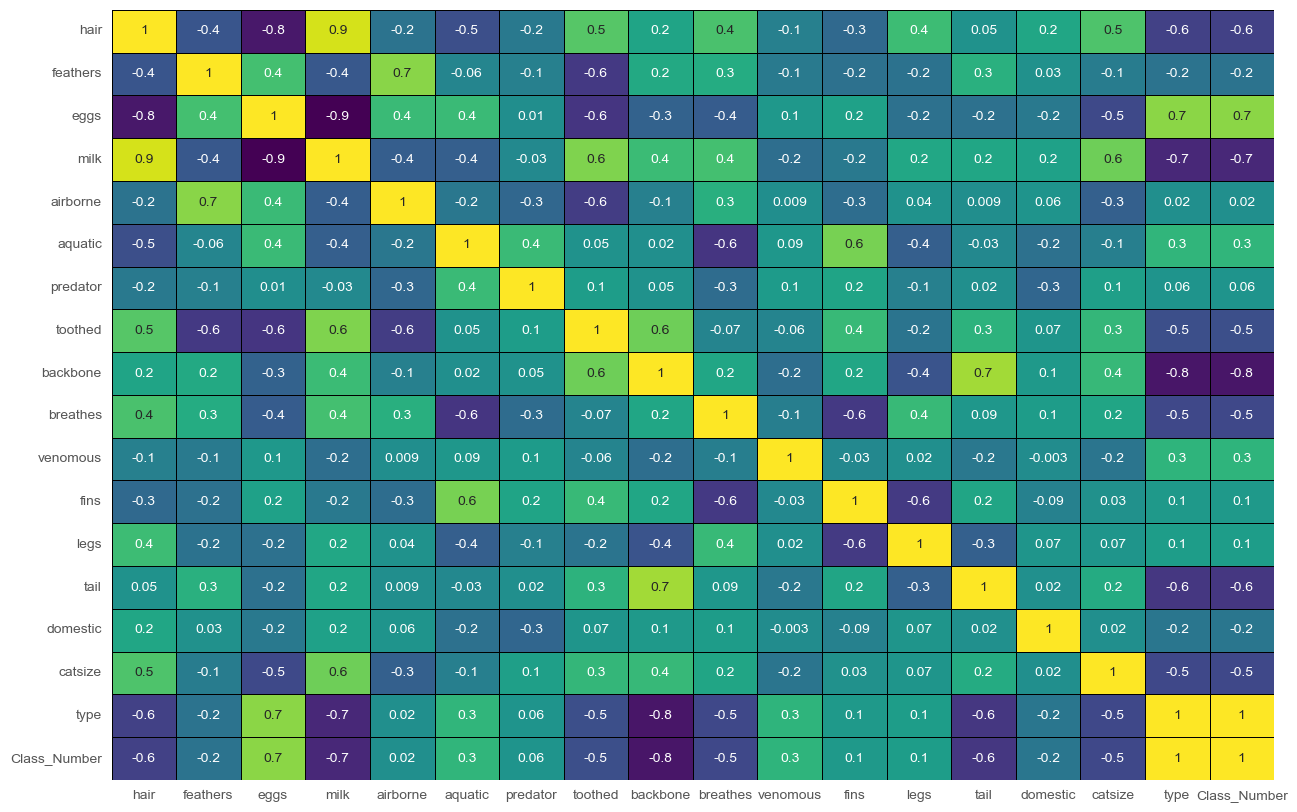

In [108]:
# Having a look at the correlation matrix

fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(zoo.corr(), annot=True, fmt='.1g', cmap="viridis", cbar=False, linewidths=0.5, linecolor='black')


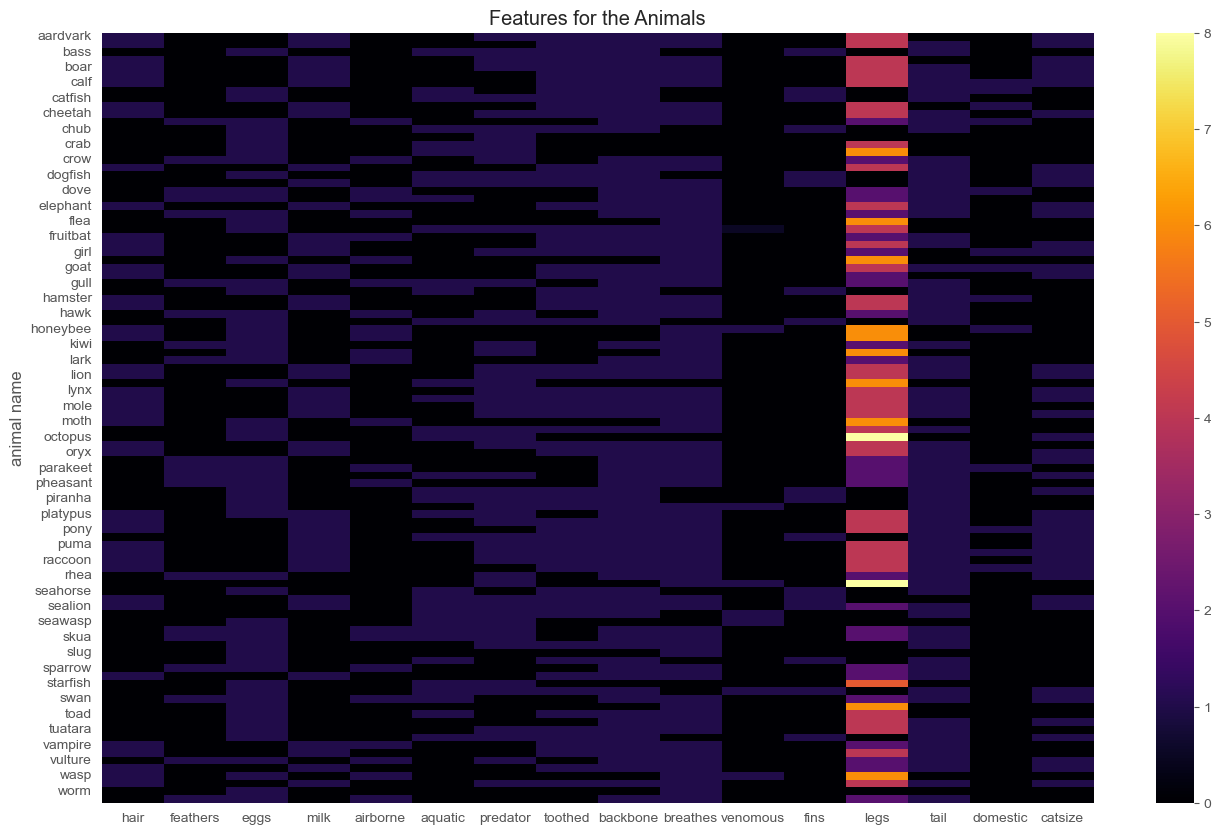

In [109]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'zoo' is your DataFrame containing the zoo dataset

# Drop irrelevant columns
zoo_df_temp = zoo.drop(['type', 'Class_Number'], axis=1)

# Group by animal_name and calculate mean for each feature
zoo_df_temp = zoo_df_temp.groupby(by='animal name').mean()

# Set the size of the plot
plt.rcParams['figure.figsize'] = (16, 10)

# Create the heatmap
sns.heatmap(zoo_df_temp, cmap="inferno")

# Set title
ax = plt.gca()
ax.set_title("Features for the Animals")

# Show the plot
plt.show()



We can also see if there are any trends or correlations in the data using a heatmap.

As mentioned previously, we will want to treat the legs columns differently as it does not present data the same way as the remaining columns. So, we will create a column has_legs that checks if an animal has legs (1) or not (0).



In [110]:
zoo_df = zoo.copy()
zoo_df['has_legs'] = np.where(zoo_df['legs']>0,1,0)
zoo_df = zoo_df[['animal name','hair','feathers','eggs','milk', 'airborne', 'aquatic', 'predator', 'toothed', 'backbone', 'breathes','venomous','fins','legs','has_legs','tail','domestic','catsize','Class_Number','Class_Type']]
zoo_df.head()


,animal name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,has_legs,tail,domestic,catsize,Class_Number,Class_Type
0,aardvark,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,0,1,1,Mammal
1,antelope,1,0,0,1,0,0,0,1,1,1,0,0,4,1,1,0,1,1,Mammal
2,bass,0,0,1,0,0,1,1,1,1,0,0,1,0,0,1,0,0,4,Fish
3,bear,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,0,1,1,Mammal
4,boar,1,0,0,1,0,0,1,1,1,1,0,0,4,1,1,0,1,1,Mammal


Text(0.5, 1.0, 'Features for the Animals')

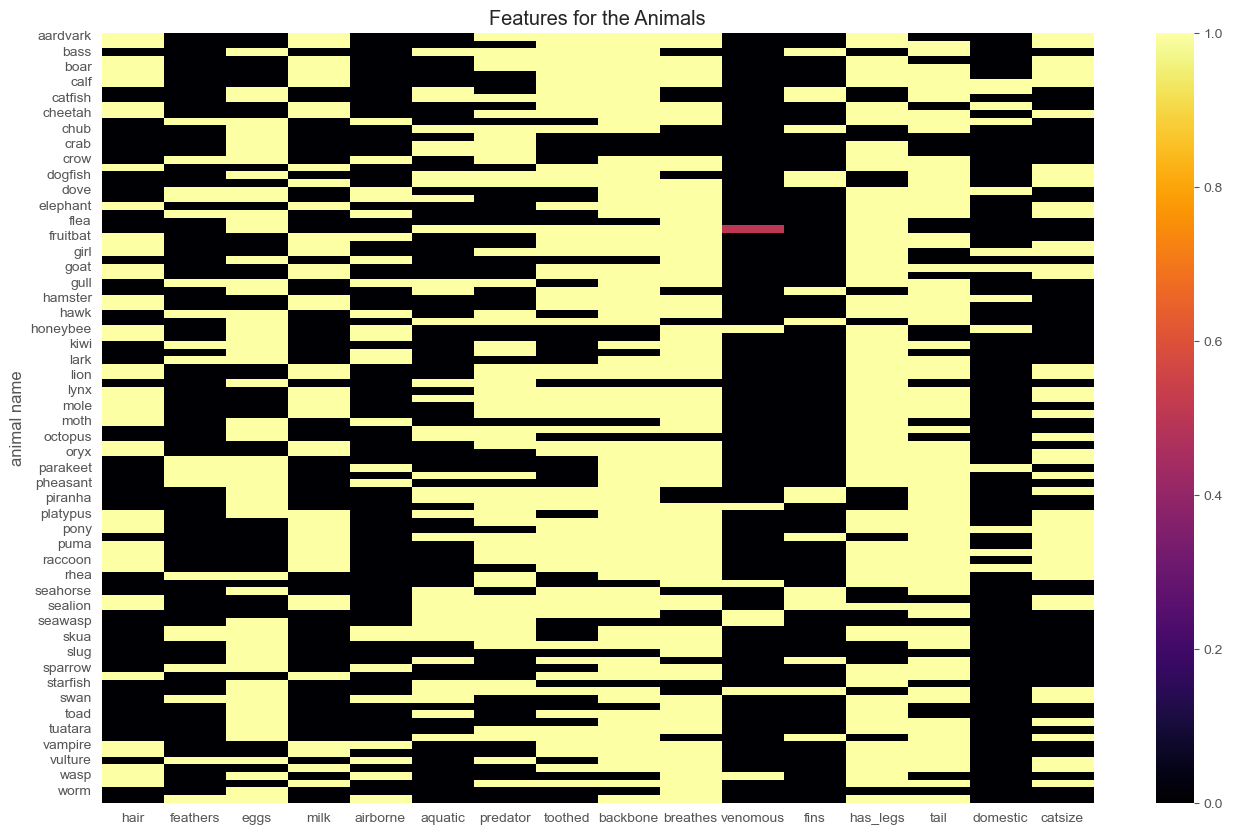

In [111]:
zoo_df_temp = zoo_df.drop(['legs','Class_Number','Class_Type'], axis=1)
zoo_df_temp = zoo_df_temp.groupby(by='animal name').mean()
plt.rcParams['figure.figsize'] = (16,10) 
sns.heatmap(zoo_df_temp, cmap="inferno")
ax = plt.gca()
ax.set_title("Features for the Animals")


In [112]:
zoo.columns


Index(['animal name', 'hair', 'feathers', 'eggs', 'milk', 'airborne',
       'aquatic', 'predator', 'toothed', 'backbone', 'breathes', 'venomous',
       'fins', 'legs', 'tail', 'domestic', 'catsize', 'type', 'Class_Number',
       'Class_Type'],
      dtype='object')

Text(0.5, 1.0, 'Histogram of Classes')

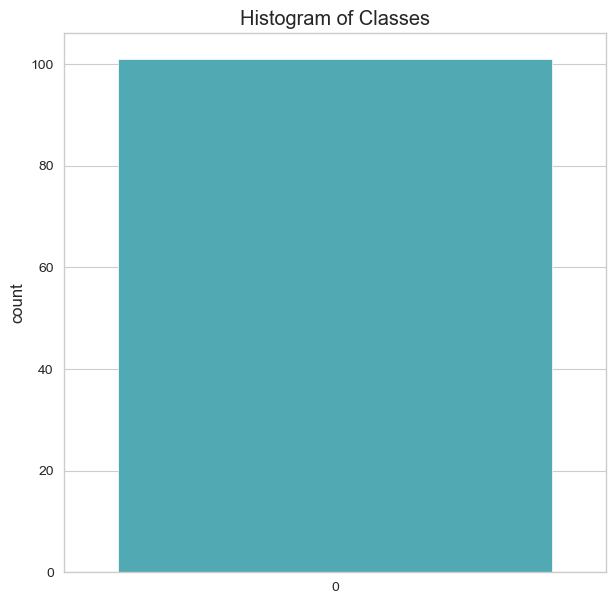

In [113]:
# Set default plot grid
sns.set_style('whitegrid')
# Plot histogram of classes
plt.rcParams['figure.figsize'] = (7,7)
sns.countplot(zoo['type'], palette='YlGnBu')
ax = plt.gca()
ax.set_title("Histogram of Classes")


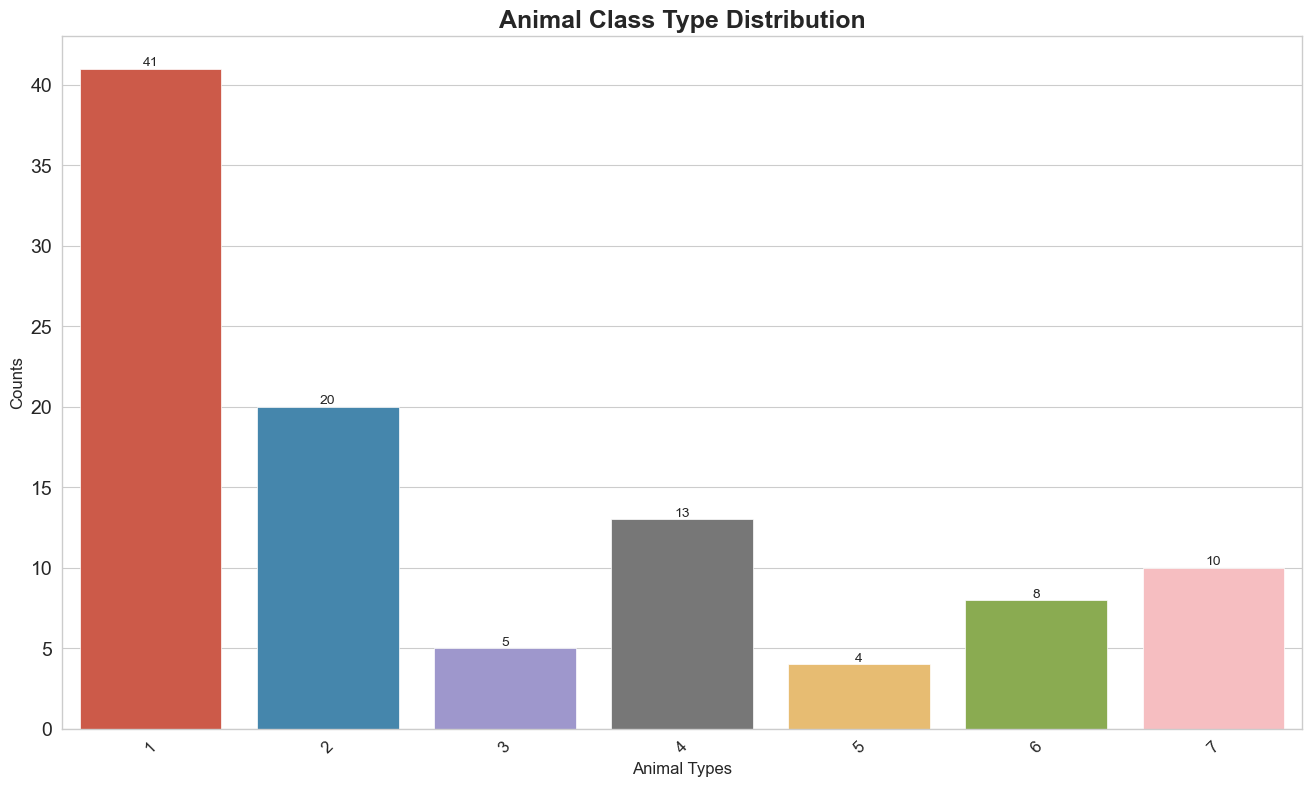

In [114]:
plt.figure(figsize = (16,9))
ax = sns.barplot(x = zoo['type'].value_counts().index.tolist(), y = zoo['type'].value_counts().tolist())
plt.yticks(rotation = 0, fontsize = 14)
plt.xticks(rotation = 45, fontsize = 12)
plt.title("Animal Class Type Distribution",  fontsize = 18, fontweight = 'bold')
plt.xlabel('Animal Types')
plt.ylabel('Counts')
for i in ax.containers:
    ax.bar_label(i,)


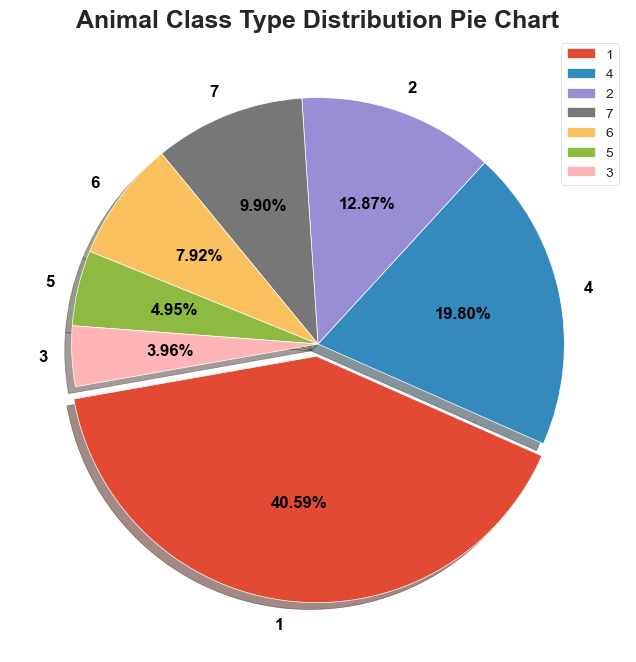

In [115]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

# Replace 'zoo.Class_Type.unique()' with 'zoo['type'].unique()' if 'type' is the correct column
plt.pie(zoo['type'].value_counts(),
        labels=zoo['type'].unique(),
        explode=[0.05] + [0] * (len(zoo['type'].unique()) - 1),  # Explode the first slice slightly
        autopct='%.2f%%',
        shadow=True,
        startangle=190,
        textprops={'size': 'large', 'fontweight': 'bold', 'color': 'black'})

plt.legend(loc='upper right')
plt.title("Animal Class Type Distribution Pie Chart", fontsize=18, fontweight='bold')
plt.show()


The 7 Class Types are:

1. Mammal

2. Fish

3. Bird

4. Invertebrate

5. Bug

6. Amphibian

7. Reptile



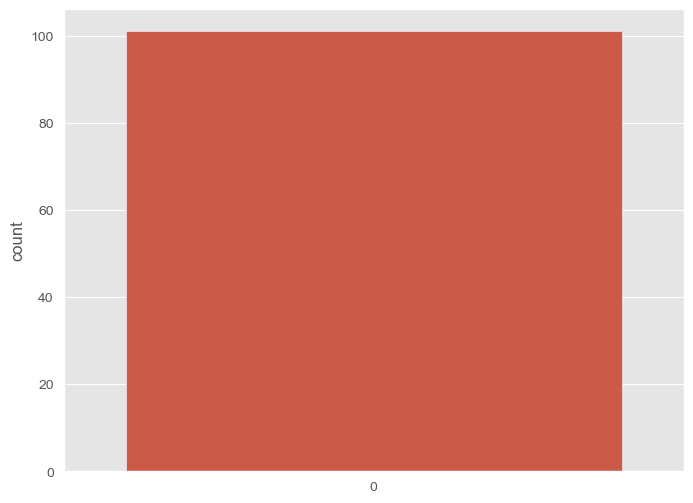

In [116]:
 plt.style.use("ggplot")
fig, ax = plt.subplots(figsize=(8,6))
sns.countplot(zoo["legs"]);


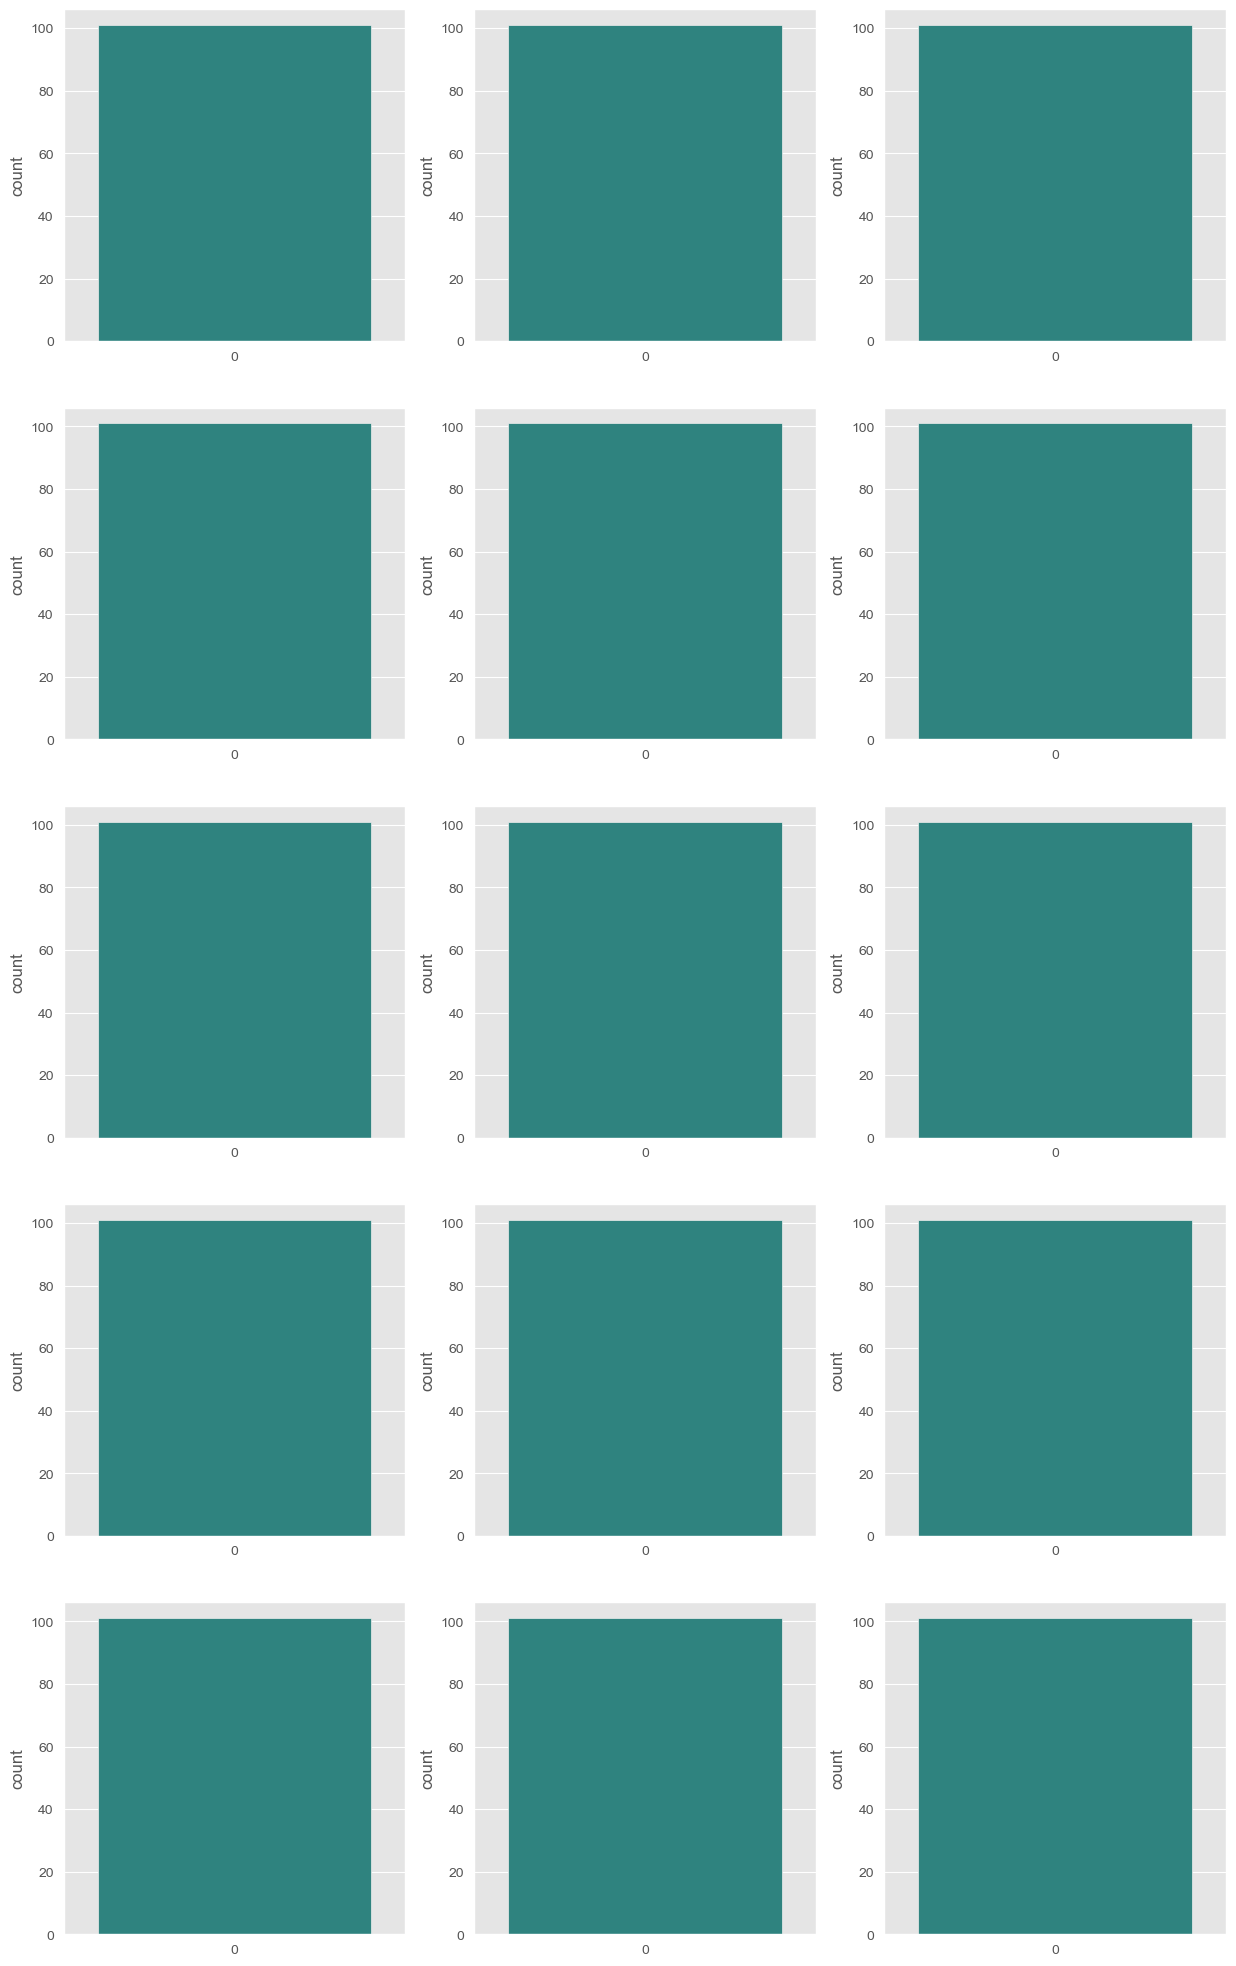

In [117]:
plt.style.use("ggplot")
fig, ax =plt.subplots(5,3, figsize=(15,25)) 

sns.countplot(zoo["domestic"], palette="viridis", ax=ax[0,0])
sns.countplot(zoo["hair"], palette="viridis", ax=ax[0,1])
sns.countplot(zoo["feathers"], palette="viridis", ax=ax[0,2])

sns.countplot(zoo["eggs"], palette="viridis", ax=ax[1,0])
sns.countplot(zoo["milk"], palette="viridis", ax=ax[1,1])
sns.countplot(zoo["airborne"], palette="viridis", ax=ax[1,2])

sns.countplot(zoo["aquatic"], palette="viridis", ax=ax[2,0])
sns.countplot(zoo["predator"], palette="viridis", ax=ax[2,1])
sns.countplot(zoo["toothed"], palette="viridis", ax=ax[2,2])

sns.countplot(zoo["backbone"], palette="viridis", ax=ax[3,0])
sns.countplot(zoo["breathes"], palette="viridis", ax=ax[3,1])
sns.countplot(zoo["venomous"], palette="viridis", ax=ax[3,2])

sns.countplot(zoo["fins"], palette="viridis", ax=ax[4,0])
sns.countplot(zoo["tail"], palette="viridis", ax=ax[4,1])
sns.countplot(zoo["catsize"], palette="viridis", ax=ax[4,2]);


## 4. Data Pre-Processing


In [118]:
zoo.drop(['type', 'animal name', 'Class_Number'], axis=1, inplace=True)


In [119]:
zoo.head(1)


,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,Class_Type
0,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,Mammal


## Test Train Split and Cross Validation methods
Train Test Split : To have unknown datapoints to test the data rather than testing with the same points with which the model was trained. This helps capture the model performance much better.

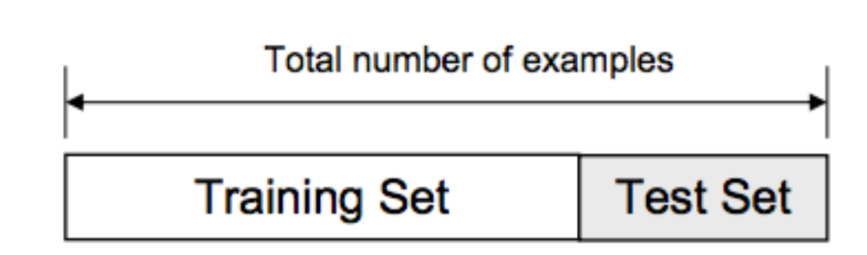

Cross Validation: When model is split into training and testing it can be possible that specific type of data point may go entirely into either training or testing portion. This would lead the model to perform poorly. Hence over-fitting and underfitting problems can be well avoided with cross validation techniques

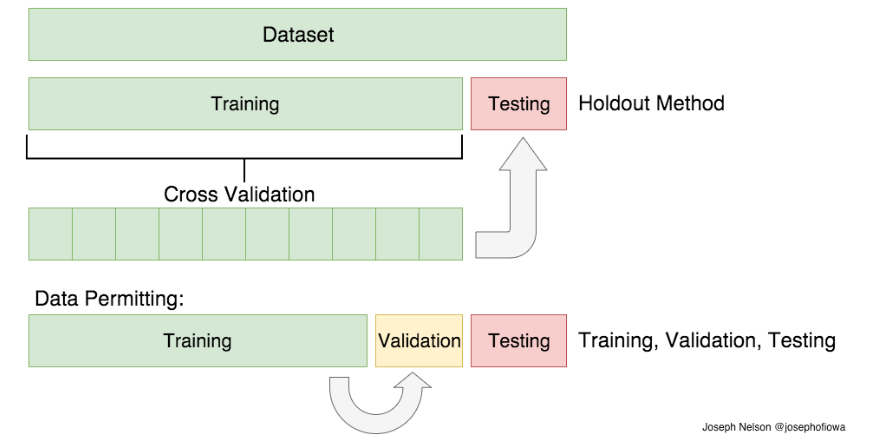

About Stratify : Stratify parameter makes a split so that the proportion of values in the sample produced will be the same as the proportion of values provided to parameter stratify.

For example, if variable y is a binary categorical variable with values 0 and 1 and there are 25% of zeros and 75% of ones, stratify=y will make sure that your random split has 25% of 0's and 75% of 1's.

For Reference : https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6



In [120]:
x = zoo.drop('Class_Type',axis=1)
y = zoo[['Class_Type']]


In [121]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=0)


In [122]:
print("Shape of X_train: ",x_train.shape)
print("Shape of X_test: ", x_test.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of y_test",y_test.shape)


Shape of X_train:  (70, 16)
Shape of X_test:  (31, 16)
Shape of y_train:  (70, 1)
Shape of y_test (31, 1)


## 5. How to choose the value for K?
K is a crucial parameter in the KNN algorithm. Some suggestions for choosing K Value are:



1. Using error curves: The figure below shows error curves for different values of K for training and test data.
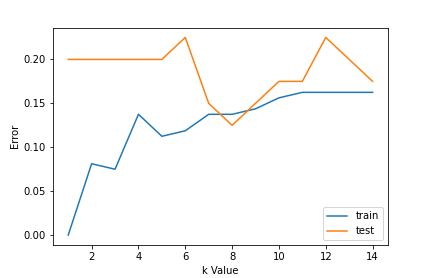

# 5.1 Grid search for choosing the best Value of K


In [123]:
# Get score for different values of n
k_list = np.arange(1, 40, 2)
mean_scores = []
accuracy_list = []
error_rate = []

for i in k_list:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_train,y_train)
    pred_i = knn.predict(x_test)
    pred_i = pred_i.reshape(31,1)
    score = cross_val_score(knn,x_train, y_train,cv=10)
    mean_scores.append(np.mean(score))
    error_rate.append(np.mean(pred_i != y_test))


In [124]:
n_neighbors = np.array([2*i+1 for i in range(1,20)])
param_grid = dict(n_neighbors=n_neighbors)
n_neighbors


array([ 3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35,
       37, 39])

In [125]:
model = KNeighborsClassifier()
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv =10)
grid.fit(x, y)


GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35,
       37, 39])})

In [126]:
print(grid.best_score_)
print(grid.best_params_)


0.95
{'n_neighbors': 3}


It is recommended to always select an odd value of K ~ When the value of K is set to even, a situation may arise in which the elements from both groups are equal. In the diagram below, elements from both groups are equal in the internal “Red” circle (k == 4).

In this condition, the model would be unable to do the correct classification for you. Here the model will randomly assign any of the two classes to this new unknown data.

Choosing an odd value for K is preferred because such a state of equality between the two classes would never occur here. Due to the fact that one of the two groups would still be in the majority, the value of K is selected as odd.

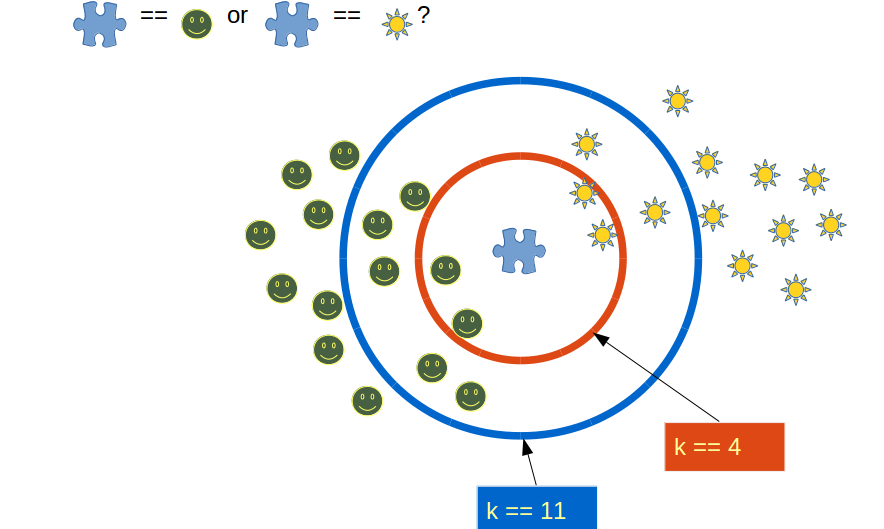

## 5.2 Visualizing the CV results


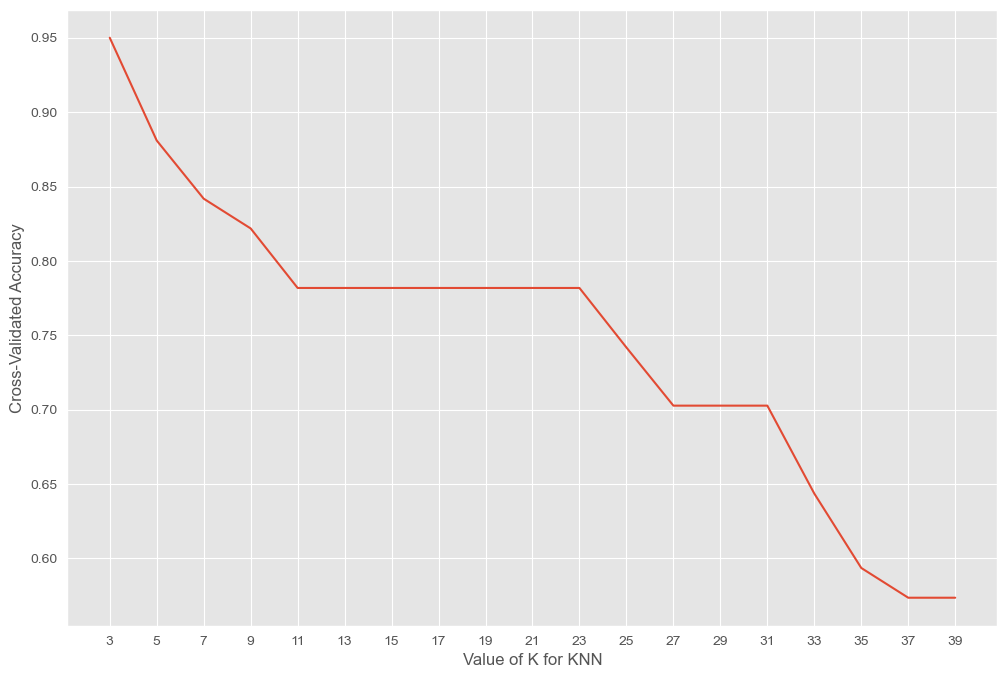

In [127]:
import matplotlib.pyplot as plt 
%matplotlib inline
# choose k between 1 to 40
k_range = np.array([2*i+1 for i in range(1,20)])
k_scores = []
# use iteration to caclulator different k in models, then return the average accuracy based on the cross validation
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, x, y, cv=10)
    k_scores.append(scores.mean())
# plot to see clearly
plt.figure(figsize=(12,8))
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.xticks(k_range)
plt.show()


In [128]:
pd.DataFrame(k_scores).sort_values(0,ascending=False).head(10)


,0
0,0.950000
1,0.880909
2,0.841818
3,0.821818
7,0.781818
10,0.781818
8,0.781818
9,0.781818
6,0.781818
5,0.781818


#### We can either take K = 9 or 3


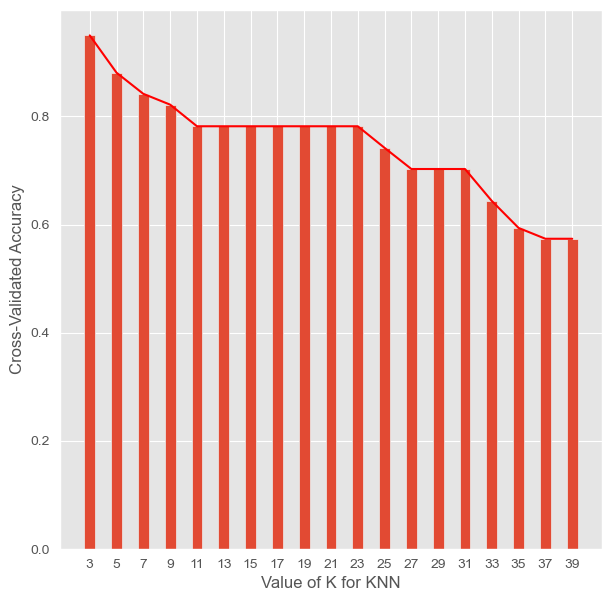

<Figure size 1200x800 with 0 Axes>

In [129]:
import matplotlib.pyplot as plt 
%matplotlib inline
# choose k between 1 to 20
k_range = [2*i+1 for i in range(1,20)]
k_scores = []
# use iteration to caclulator different k in models, then return the average accuracy based on the cross validation
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, x, y, cv=10)
    k_scores.append(scores.mean())
# plot to see clearly
plt.bar(k_range, k_scores)
plt.plot(k_range, k_scores, color='red')
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.xticks(k_range)
plt.figure(figsize=(12,8))
plt.show()


Text(0, 0.5, 'Error Rate')

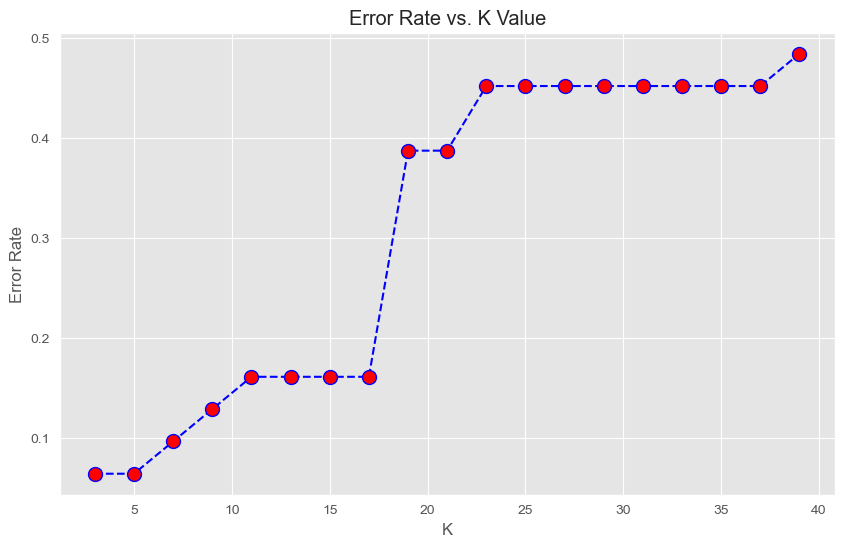

In [130]:
error_rate = []

# Will take some time
k_range = [i for i in range(3,40, 2)]
for i in k_range:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_train,y_train)
    pred_i = knn.predict(x_test)
    pred_i = pred_i.reshape(31,1)
    error_rate.append(np.mean(pred_i != y_test))
plt.figure(figsize=(10,6))
plt.plot([i for i in range(3,40, 2)],error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')


Here we can see that that after K>3 the error rate just tends to hover around 0-0.5 Let's retrain the model with that and check the classification report!



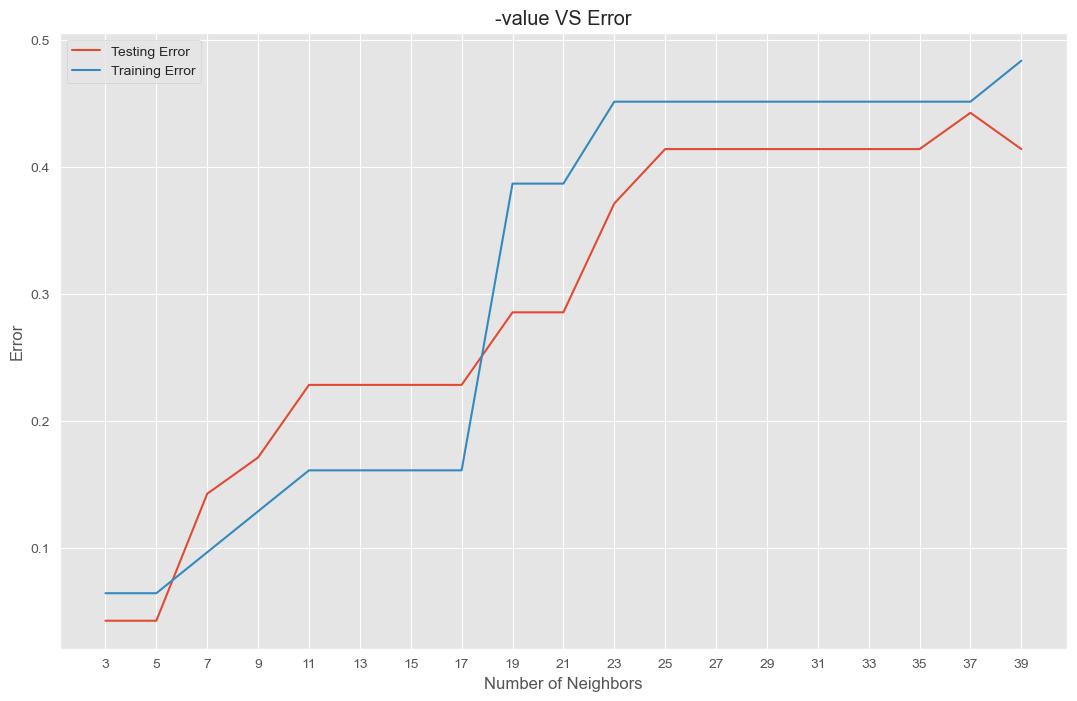

In [131]:
error1= []
error2= []
k_range = [i for i in range(3,40, 2)]
for k in k_range:
    knn= KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train,y_train)
    y_pred1= knn.predict(x_train)
    y_pred1 = y_pred1.reshape(70,1)
    error1.append(np.mean(y_train!= y_pred1))
    y_pred2= knn.predict(x_test)
    y_pred2 = y_pred2.reshape(31,1)
    error2.append(np.mean(y_test!= y_pred2))
# Plot
plt.figure(figsize=[13,8])
plt.plot(k_range, error1, label = 'Testing Error')
plt.plot(k_range, error2, label = 'Training Error')
plt.legend()
plt.title('-value VS Error')
plt.xlabel('Number of Neighbors')
plt.ylabel('Error')
plt.xticks(k_range)
plt.show()


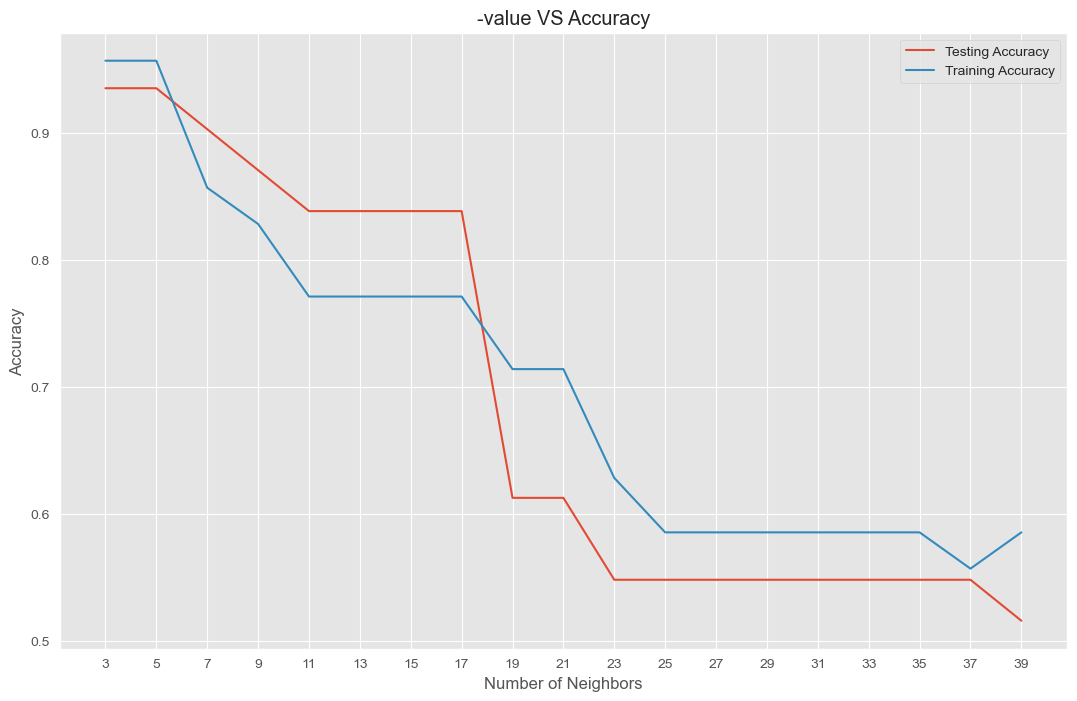

In [132]:
train_accuracy = []
test_accuracy = []

k_range = [i for i in range(3,40, 2)]
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    # Fit with knn
    knn.fit(x_train,y_train)
    #train accuracy
    train_accuracy.append(knn.score(x_train,y_train))
    # test accuracy
    test_accuracy.append(knn.score(x_test,y_test))
# Plot
plt.figure(figsize=[13,8])
plt.plot(k_range, test_accuracy, label = 'Testing Accuracy')
plt.plot(k_range, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.title('-value VS Accuracy')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.xticks(k_range)
plt.savefig('graph.png')
plt.show()

The impact of selecting a smaller or larger K value on the model

Larger K value: The case of underfitting occurs when the value of k is increased. In this case, the model would be unable to correctly learn on the training data.

Smaller k value: The condition of overfitting occurs when the value of k is smaller. The model will capture all of the training data, including noise. The model will perform poorly for the test data in this scenario.
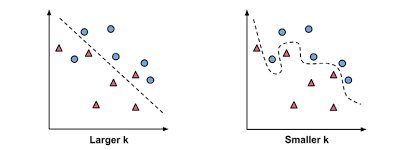
The best value of K is 3 or 5 lets check for these value in classifiaction Report


#### 6. Applying KNN
#### How does KNN Work?
Principle: Consider the following figure. Let us say we have plotted data points from our training set on a two-dimensional feature space. As shown, we have a total of 6 data points (3 red and 3 blue). Red data points belong to ‘class1’ and blue data points belong to ‘class2’. And yellow data point in a feature space represents the new point for which a class is to be predicted. Obviously, we say it belongs to ‘class1’ (red points)

Why?

Because its nearest neighbors belong to that class!

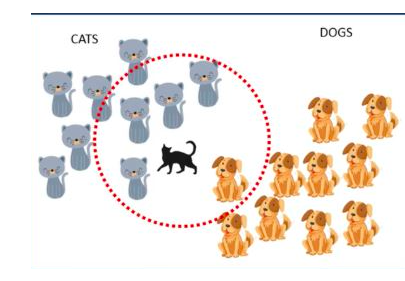

Yes, this is the principle behind K Nearest Neighbors. Here, nearest neighbors are those data points that have minimum distance in feature space from our new data point. And K is the number of such data points we consider in our implementation of the algorithm. Therefore, distance metric and K value are two important considerations while using the KNN algorithm. Euclidean distance is the most popular distance metric. You can also use Hamming distance, Manhattan distance, Minkowski distance as per your need. For predicting class/ continuous value for a new data point, it considers all the data points in the training dataset. Finds new data point’s ‘K’ Nearest Neighbors (Data points) from feature space and their class labels or continuous values.



#### Predictions and Evaluations
Let's evaluate our KNN model!



### 1. Confusion Matrix
The confusion matrix is a technique used for summarizing the performance of a classification algorithm i.e. it has binary outputs. 

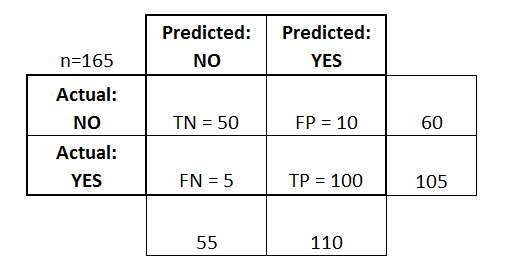

### In the famous cancer example:
Cases in which the doctor predicted YES (they have the disease), and they do have the disease will be termed as TRUE POSITIVES (TP). The doctor has correctly predicted that the patient has the disease.
Cases in which the doctor predicted NO (they do not have the disease), and they don’t have the disease will be termed as TRUE NEGATIVES (TN). The doctor has correctly predicted that the patient does not have the disease.
Cases in which the doctor predicted YES, and they do not have the disease will be termed as FALSE POSITIVES (FP). Also known as “Type I error”.
Cases in which the doctor predicted NO, and they have the disease will be termed as FALSE NEGATIVES (FN). Also known as “Type II error”.
For Reference: https://medium.com/@djocz/confusion-matrix-aint-that-confusing-d29e18403327



#### 2. Classification Report
Report which includes Precision, Recall and F1-Score.

#### Precision Score
    TP – True Positives
    FP – False Positives

    Precision – Accuracy of positive predictions.
    Precision = TP/(TP + FP)
    
#### Recall Score
    FN – False Negatives

    Recall(sensitivity or true positive rate): Fraction of positives that were correctly identified.
    Recall = TP/(TP+FN)
    
#### F1 Score
    F1 Score (aka F-Score or F-Measure) – A helpful metric for comparing two classifiers.
    F1 Score takes into account precision and the recall. 
    It is created by finding the the harmonic mean of precision and recall.

    F1 = 2 x (precision x recall)/(precision + recall)


Precision - Precision is the ratio of correctly predicted positive observations to the total predicted positive observations. The question that this metric answer is of all passengers that labeled as survived, how many actually survived? High precision relates to the low false positive rate. We have got 0.788 precision which is pretty good.

Precision = TP/TP+FP

Recall (Sensitivity) - Recall is the ratio of correctly predicted positive observations to the all observations in actual class - yes. The question recall answers is: Of all the passengers that truly survived, how many did we label? A recall greater than 0.5 is good.

Recall = TP/TP+FN

F1 score - F1 Score is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. Intuitively it is not as easy to understand as accuracy, but F1 is usually more useful than accuracy, especially if you have an uneven class distribution. Accuracy works best if false positives and false negatives have similar cost. If the cost of false positives and false negatives are very different, it’s better to look at both Precision and Recall.

F1 Score = 2*(Recall * Precision) / (Recall + Precision)

For Reference: http://joshlawman.com/metrics-classification-report-breakdown-precision-recall-f1/ : https://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/



### 6.2 Applying KNN using K=3


In [133]:
# NOW WITH K=3
knn = KNeighborsClassifier(n_neighbors=3)

knn.fit(x_train,y_train)
pred = knn.predict(x_test)

print('WITH K=3')
print('\n')
print(confusion_matrix(y_test,pred))
print('\n')
print(classification_report(y_test,pred))


WITH K=3


[[ 1  0  0  0  0  0  0]
 [ 0  6  0  0  0  0  0]
 [ 0  0  2  0  0  0  0]
 [ 0  0  0  7  0  0  0]
 [ 0  0  0  0  2  0  0]
 [ 0  0  0  0  0 11  0]
 [ 0  0  0  2  0  0  0]]


              precision    recall  f1-score   support

   Amphibian       1.00      1.00      1.00         1
        Bird       1.00      1.00      1.00         6
         Bug       1.00      1.00      1.00         2
        Fish       0.78      1.00      0.88         7
Invertebrate       1.00      1.00      1.00         2
      Mammal       1.00      1.00      1.00        11
     Reptile       0.00      0.00      0.00         2

    accuracy                           0.94        31
   macro avg       0.83      0.86      0.84        31
weighted avg       0.89      0.94      0.91        31



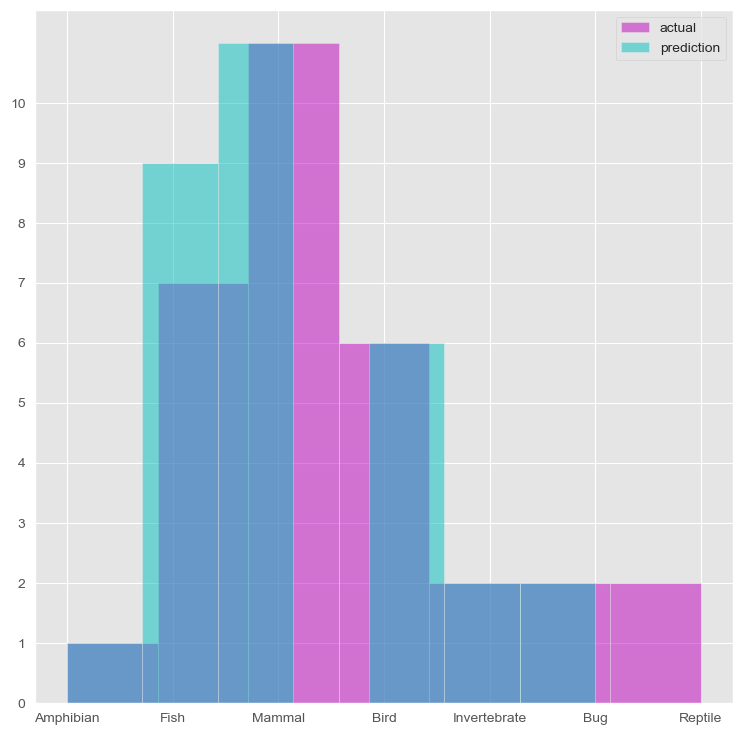

In [134]:
plt.rcParams['figure.figsize'] = (9,9) 
_, ax = plt.subplots()
ax.hist(y_test, color = 'm', alpha = 0.5, label = 'actual', bins=7)
ax.hist(pred, color = 'c', alpha = 0.5, label = 'prediction', bins=7)
ax.yaxis.set_ticks(np.arange(0,11))
ax.legend(loc = 'best')
plt.show()


### 6.3 Applying KNN using K=5


In [135]:
# NOW WITH K=5
knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(x_train,y_train)
pred = knn.predict(x_test)

print('WITH K=5')
print('\n')
print(confusion_matrix(y_test,pred))
print('\n')
print(classification_report(y_test,pred))


WITH K=5


[[ 1  0  0  0  0  0  0]
 [ 0  6  0  0  0  0  0]
 [ 0  0  2  0  0  0  0]
 [ 0  0  0  7  0  0  0]
 [ 0  0  0  0  2  0  0]
 [ 0  0  0  0  0 11  0]
 [ 0  0  0  2  0  0  0]]


              precision    recall  f1-score   support

   Amphibian       1.00      1.00      1.00         1
        Bird       1.00      1.00      1.00         6
         Bug       1.00      1.00      1.00         2
        Fish       0.78      1.00      0.88         7
Invertebrate       1.00      1.00      1.00         2
      Mammal       1.00      1.00      1.00        11
     Reptile       0.00      0.00      0.00         2

    accuracy                           0.94        31
   macro avg       0.83      0.86      0.84        31
weighted avg       0.89      0.94      0.91        31



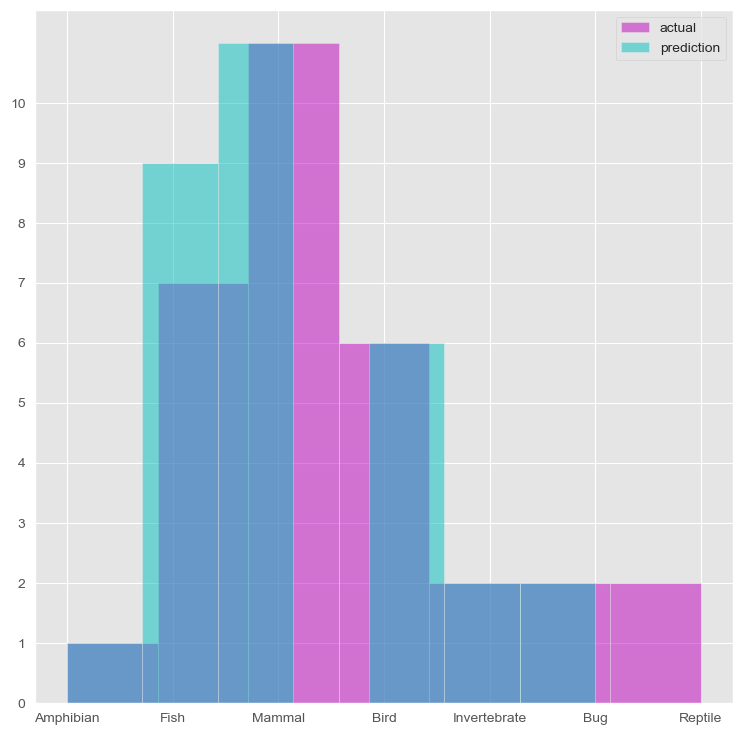

In [136]:
plt.rcParams['figure.figsize'] = (9,9) 
_, ax = plt.subplots()
ax.hist(y_test, color = 'm', alpha = 0.5, label = 'actual', bins=7)
ax.hist(pred, color = 'c', alpha = 0.5, label = 'prediction', bins=7)
ax.yaxis.set_ticks(np.arange(0,11))
ax.legend(loc = 'best')
plt.show()


What this figure tells us is the total number of animals in each class according to the test data and predicted data. We can see that the predictions matches almost all the actual animal classifications (indicated by color overlap) except for one case where the model failed to identify an animal as belonging to class 3 (Reptile), and marked it as being in class 4 (Fish).

So we can see the level of accuracy for this particular classifier.

Now that we know what the model can do at n=5, we should run the model for multiple values of n to find optimal value of n with respect to this dataset.

So, we've seen how this works when we use all the features values as given. Just for fun, let's see how this changes if we don't use the values for legs and use has_legs instead as we did when plotting our heatmap.

I'll run the exact same code as before changing nothing but using has_legs and not legs.



## Inference
#### So interestingly,
Replacing the feature legs with has_legs improved the accuracy of KNN models at every value where n >3 This may be due to the model taking the number of legs as a continuous, numeric data point rather than as an enumerate.

